In [1]:
from deepvisualinsight.MMS import MMS
import deepvisualinsight.utils as utils
import sys
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import json
import tensorflow as tf

DATASET = "cifar10"
content_path = "/home/xianglin/projects/DVI_data/resnet18_{}".format(DATASET)

sys.path.append(content_path)
from Model.model import *
net = resnet18()

classes = ("airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

mms = MMS(content_path, net, 1, 7, 1, 512, 10, classes, temperature=.3, batch_size=500, cmap="tab10", resolution=100, verbose=1, 
transfer_learning=True, attention=True, temporal=True, step3=False, split=-1,  alpha=0.3, withoutB=False, attack_device="cuda:2");



2022-08-11 22:18:09.491786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 22:18:09.492095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 22:18:09.492350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 22:18:09.492602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-11 22:18:09.496832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Finish loading content!


# test invariants functions

In [16]:
mms.fixing_invariants_train(180,200,0.5)

100%|██████████| 250/250 [00:00<00:00, 17356.22it/s]


Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f757c17e990>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f750c0b0e90>


(45, 1627)

In [19]:
i=20
nn_train = mms.proj_nn_perseverance_knn_train(i, 15)
nn_test = mms.proj_nn_perseverance_knn_test(i, 15)
ppr_train = mms.inv_accu_train(i)
ppr_test = mms.inv_accu_test(i)

Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f750c7b3fd0>
Thu Aug 11 22:25:30 2022 Building RP forest with 16 trees
Thu Aug 11 22:25:31 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Aug 11 22:25:33 2022 Building RP forest with 16 trees
Thu Aug 11 22:25:33 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f7589912ed0>
Thu Aug 11 22:25:36 2022 Building RP forest with 17 trees
Thu Aug 11 22:25:37 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations
Thu Aug 11 22:25:39 2022 Building RP forest with 17 trees
Thu Aug 11 22:25:39 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Keras encoder mo

100%|██████████| 250/250 [00:00<00:00, 17045.30it/s]

Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f750c328950>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f75894cd290>


100%|██████████| 50/50 [00:00<00:00, 15963.71it/s]


In [20]:
nn_train, nn_test, ppr_train, ppr_test

(1.28718, 1.2479166666666666, 0.34744, 0.3431)

In [ ]:
prev_data = mms.get_epoch_train_repr_data(1)
curr_data = mms.get_epoch_train_repr_data(2)
dists = np.linalg.norm(prev_data - curr_data, axis=1)
dists.shape

In [ ]:
encoder = mms.get_proj_model(1)
prev_embedding = encoder(prev_data).cpu().numpy()

encoder = mms.get_proj_model(2)
curr_embedding = encoder(curr_data).cpu().numpy()

embedding_dists = np.linalg.norm(prev_embedding-curr_embedding, axis=1)

In [ ]:
high_change = np.argsort(dists)
low_change= np.argsort(embedding_dists)
targets = np.intersect1d(high_change[49000:],low_change[49000:])
targets.shape

In [ ]:
targets = np.load("/home/xianglin/projects/git_space/SingleVisualization/wrong_pred.npy")

In [ ]:
save_dir = "./result"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
for i in range(5, 8, 1):
    curr_data = mms.get_epoch_train_repr_data(i)
    curr_data = curr_data[targets]
    pred = mms.get_pred(i, curr_data)
    pred = np.argmax(pred, axis=1)
    labels = mms.get_epoch_train_labels(i)
    labels = labels[targets]
    mms.savefig_cus(i, curr_data, pred, labels, path=os.path.join(save_dir,"motivated_{}_{}.png".format(DATASET, i)))

In [ ]:
from scipy.stats.stats import pearsonr
corr = pearsonr(dists, embedding_dists)
corr

# temporal ranking

In [2]:
EPOCH = 50
LEN = 60000

In [3]:
high_repr = np.zeros((EPOCH,LEN,512))
low_repr = np.zeros((EPOCH,LEN,2))
for i in range(EPOCH):
    high_repr[i] = mms.get_epoch_train_repr_data(i+1)
    low_repr[i] = mms.batch_project(high_repr[i], i+1)


2022-04-12 22:25:33.956850: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 22:25:34.138532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 22:25:34.138820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 22:25:34.139074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f6ff5de2350>
Instructions for updating:
Use tf.identity instead.


2022-04-12 22:25:35.696239: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f6f122e96d0>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f6f12857790>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f6f11aba790>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f6f11744590>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f6f11bf5750>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f6f11072f10>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f6f110ff6d0>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f6f1256aad0>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f6f1127fed0>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7f6f12c64850>
Keras encoder model loaded from <keras.engine.sequential.Seq

In [4]:
from scipy import stats
epochs = [i for i in range(EPOCH)]
corrs = np.zeros((EPOCH,500))
ps = np.zeros((EPOCH,500))
for i in range(500):
    high_embeddings = high_repr[:,i,:].squeeze()
    low_embeddings = low_repr[:,i,:].squeeze()
    for e in epochs:
        high_dists = np.linalg.norm(high_embeddings - high_embeddings[e], axis=1)
        low_dists = np.linalg.norm(low_embeddings - low_embeddings[e], axis=1)
        corr, p = stats.spearmanr(high_dists, low_dists)
        corrs[e][i] = corr
        ps[e][i] = p


<function matplotlib.pyplot.show(close=None, block=None)>

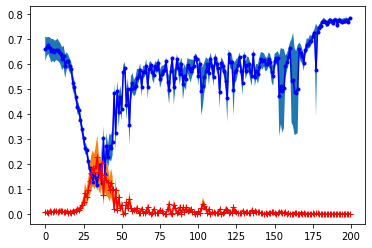

In [7]:
import matplotlib.pyplot as plt
mean_corr = np.mean(corrs, axis=1)
var_corr = np.var(corrs, axis=1)

mean_p = np.mean(ps, axis=1)
var_p = np.var(ps, axis=1)


p1 = plt.plot(epochs, mean_corr, "b.-", epochs, mean_p, "r+-")
p2 = plt.fill_between(epochs, mean_corr-var_corr, mean_corr+var_corr)
p3 = plt.fill_between(epochs, mean_p-var_p, mean_p+var_p)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

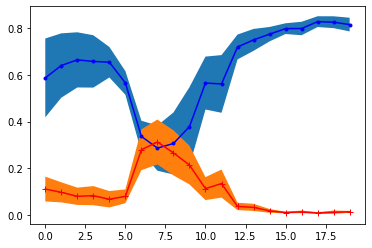

In [5]:
import matplotlib.pyplot as plt
mean_corr = np.mean(corrs, axis=1)
var_corr = np.var(corrs, axis=1)

mean_p = np.mean(ps, axis=1)
var_p = np.var(ps, axis=1)


p1 = plt.plot(epochs, mean_corr, "b.-", epochs, mean_p, "r+-")
p2 = plt.fill_between(epochs, mean_corr-var_corr, mean_corr+var_corr)
p3 = plt.fill_between(epochs, mean_p-var_p, mean_p+var_p)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

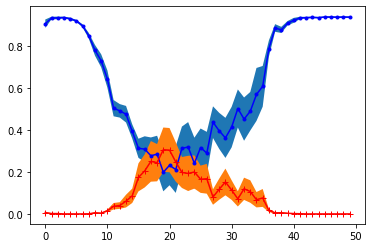

In [5]:
import matplotlib.pyplot as plt
mean_corr = np.mean(corrs, axis=1)
var_corr = np.var(corrs, axis=1)

mean_p = np.mean(ps, axis=1)
var_p = np.var(ps, axis=1)


p1 = plt.plot(epochs, mean_corr, "b.-", epochs, mean_p, "r+-")
p2 = plt.fill_between(epochs, mean_corr-var_corr, mean_corr+var_corr)
p3 = plt.fill_between(epochs, mean_p-var_p, mean_p+var_p)
plt.show

# fixing invarient

In [2]:
from scipy.special import softmax
from scipy import stats
from scipy.spatial.distance import cosine

In [3]:
e_s = 20
e_t = 40

In [11]:
train_data_s = mms.get_epoch_train_repr_data(e_s)
train_data_t = mms.get_epoch_train_repr_data(e_t)

pred_s = mms.get_pred(e_s, train_data_s)
pred_t = mms.get_pred(e_t, train_data_t)

low_s = mms.batch_project(train_data_s, e_s)
low_t = mms.batch_project(train_data_t, e_t)

labels = mms.training_labels.cpu().numpy()

100%|██████████| 300/300 [00:00<00:00, 17094.49it/s]


Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7ff2a69fc8d0>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7ff2a6590dd0>


In [5]:
def kl_div(p, q):
    return stats.entropy(p, q, base=2)


def js_div(p, q):
    M = (p+q)/2
    return .5*kl_div(p, M)+.5*kl_div(q, M)

In [12]:
# kl
softmax_s = softmax(pred_s, axis=1)
softmax_t = softmax(pred_t, axis=1)
kl_lists = [kl_div(softmax_s[i], softmax_t[i]) for i in range(len(softmax_t))]
dists = [cosine(low_t[i], low_s[i]) for i in range(len(low_s))]
corr, p = stats.spearmanr(kl_lists, dists)
corr, p

(0.33883432527188145, 0.0)

In [7]:
# js
js_lists = [js_div(softmax_s[i], softmax_t[i]) for i in range(len(softmax_t))]
dists = [cosine(low_t[i], low_s[i]) for i in range(len(low_s))]
corr, p = stats.spearmanr(js_lists, dists)
corr, p

(0.21084748506596782, 0.0)

In [9]:
# loss
loss_s = softmax_s[range(60000), labels]
loss_t = softmax_t[range(60000), labels]
loss_diff = np.abs(loss_s-loss_t)

dists = [cosine(low_t[i], low_s[i]) for i in range(len(low_s))]
corr, p = stats.spearmanr(js_lists, dists)
corr, p

(0.21084748506596782, 0.0)

In [19]:
# normalize low_t
mean_x = np.mean(low_t[:, 0])
mean_y = np.mean(low_t[:, 1])
low_t = low_t - [mean_x, mean_y]
low_s = low_s - [mean_x, mean_y]

max_n = np.linalg.norm(low_t)
low_t = low_t/max_n*100
low_s = low_s/max_n*100

In [20]:
np.linalg.norm((train_data_s-train_data_t),axis=1).mean(), np.linalg.norm((low_s-low_t),axis=1).mean()

(16.255549191454307, 0.0552982)

In [21]:
selected = np.argsort(kl_lists)
print("kl div")
print("fixing\t", np.linalg.norm((train_data_s-train_data_t)[selected[:100]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[:100]],axis=1).mean())
print("moving\t", np.linalg.norm((train_data_s-train_data_t)[selected[-100:]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[-100:]],axis=1).mean())

kl div
fixing	 15.756667243889462 0.077104084
moving	 19.623843760000035 0.319233


In [15]:
selected = np.argsort(js_lists)
print("js div")
print("fixing\t", np.linalg.norm((train_data_s-train_data_t)[selected[:100]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[:100]],axis=1).mean())
print("moving\t", np.linalg.norm((train_data_s-train_data_t)[selected[-100:]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[-100:]],axis=1).mean())

js div
fixing	 16.99764944227114 0.07940464
moving	 19.265289316150064 0.3256613


In [34]:
selected = np.argsort(loss_diff)
print("loss diff")
print("fixing\t", np.linalg.norm((train_data_s-train_data_t)[selected[:100]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[:100]],axis=1).mean())
print("moving\t", np.linalg.norm((train_data_s-train_data_t)[selected[-100:]],axis=1).mean(), np.linalg.norm((low_s-low_t)[selected[-100:]],axis=1).mean())

loss diff
fixing	 0.46239914135667326 0.1325778
moving	 7.489972076625427 0.4731278


# fixing invariants and moving invarients

## moving

In [44]:
e_s = 49
e_t = 50

In [45]:
train_data_s = mms.get_epoch_train_repr_data(e_s)
train_data_t = mms.get_epoch_train_repr_data(e_t)

pred_s = mms.get_pred(e_s, train_data_s)
pred_t = mms.get_pred(e_t, train_data_t)

low_s = mms.batch_project(train_data_s, e_s)
low_t = mms.batch_project(train_data_t, e_t)

labels = mms.training_labels.cpu().numpy()

100%|██████████| 300/300 [00:00<00:00, 17057.64it/s]


Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7fc8ee0d0b50>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7fc8cc59ced0>


In [46]:
resolution=500

grid_view_s, decision_view_s = mms.get_epoch_decision_view(e_s, resolution)
grid_view_t, decision_view_t = mms.get_epoch_decision_view(e_t, resolution)

grid_view_s = grid_view_s.reshape(resolution*resolution, -1)
grid_view_t = grid_view_t.reshape(resolution*resolution, -1)

s_inv_m = mms.get_inv_model(e_s)
t_inv_m = mms.get_inv_model(e_s)


grid_samples_s = s_inv_m(grid_view_s).cpu().numpy()
grid_samples_t = t_inv_m(grid_view_t).cpu().numpy()


grid_pred_s = mms.get_pred(e_s, grid_samples_s)+1e-8
grid_pred_t = mms.get_pred(e_t, grid_samples_t)+1e-8

Computing decision regions ...
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7fc9d7b22050>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7fc8cc56f650>


100%|██████████| 1250/1250 [00:00<00:00, 16981.48it/s]


Computing decision regions ...
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7fc8cc1fccd0>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7fc8c0254950>


100%|██████████| 1250/1250 [00:00<00:00, 16916.01it/s]


Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7fc8c02b23d0>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7fc9d6b18290>


100%|██████████| 1250/1250 [00:00<00:00, 16896.49it/s]


In [47]:
from deepvisualinsight.backend import is_B
s_B = is_B(pred_s)
t_B = is_B(pred_t)

predictions_s = pred_s.argmax(1)
predictions_t = pred_t.argmax(1)

confident_sample = np.logical_and(np.logical_not(s_B),np.logical_not(t_B))
diff_pred = predictions_s!=predictions_t

selected = np.logical_and(diff_pred, confident_sample)


In [48]:
grid_s_B = is_B(grid_pred_s)
grid_t_B = is_B(grid_pred_t)

grid_predictions_s = grid_pred_s.argmax(1)
grid_predictions_t = grid_pred_t.argmax(1)

In [49]:
from sklearn.neighbors import NearestNeighbors

In [50]:
high_neigh = NearestNeighbors(n_neighbors=1, radius=0.4)
high_neigh.fit(grid_view_s)
knn_dists, knn_indices = high_neigh.kneighbors(low_s, n_neighbors=1, return_distance=True)

close_s_pred = grid_predictions_s[knn_indices].squeeze()
close_s_B = grid_s_B[knn_indices].squeeze()

In [51]:
s_true = np.logical_and(close_s_pred==predictions_s, close_s_B == s_B)
np.sum(s_true[selected]), np.sum(selected)

(0, 0)

In [52]:
high_neigh = NearestNeighbors(n_neighbors=1, radius=0.4)
high_neigh.fit(grid_view_t)
knn_dists, knn_indices = high_neigh.kneighbors(low_t, n_neighbors=1, return_distance=True)

close_t_pred = grid_predictions_t[knn_indices].squeeze()
close_t_B = grid_t_B[knn_indices].squeeze()

In [53]:
t_true = np.logical_and(close_t_pred==predictions_t, close_t_B == t_B)
np.sum(t_true[selected]), np.sum(selected)

(0, 0)

In [54]:
np.sum(np.logical_and(s_true[selected], t_true[selected])), np.sum(selected)

(0, 0)

## fixing

In [93]:
# moving invariants
from scipy.special import softmax
from scipy import stats
from scipy.spatial.distance import cosine

In [94]:
def kl_div(p, q):
    return stats.entropy(p, q, base=2)


def js_div(p, q):
    M = (p+q)/2
    return .5*kl_div(p, M)+.5*kl_div(q, M)

In [95]:
e_s = 1
e_t = 3

In [96]:
train_data_s = mms.get_epoch_train_repr_data(e_s)
train_data_t = mms.get_epoch_train_repr_data(e_t)

pred_s = mms.get_pred(e_s, train_data_s)
pred_t = mms.get_pred(e_t, train_data_t)

softmax_s = softmax(pred_s, axis=1)
softmax_t = softmax(pred_t, axis=1)

low_s = mms.batch_project(train_data_s, e_s)
low_t = mms.batch_project(train_data_t, e_t)

labels = mms.training_labels.cpu().numpy();

100%|██████████| 300/300 [00:00<00:00, 17190.71it/s]


Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7fc9d62dfcd0>
Keras encoder model loaded from <keras.engine.sequential.Sequential object at 0x7fc8ee1d3090>


In [97]:
# normalize low_t
y_max = max(low_s[:, 1].max(), low_t[:, 1].max())
y_min = max(low_s[:, 1].min(), low_t[:, 1].min())
x_max = max(low_s[:, 0].max(), low_t[:, 0].max())
x_min = max(low_s[:, 0].min(), low_t[:, 0].min())
scale =min(100/(x_max - x_min), 100/(y_max - y_min))
low_t = low_t*scale
low_s = low_s*scale

In [98]:
high_dists = np.linalg.norm(train_data_s-train_data_t, axis=1)
softmax_dists = np.array([js_div(softmax_s[i], softmax_t[i]) for i in range(len(softmax_t))])
euclidean_dists = np.linalg.norm(low_s-low_t, axis=1)
# cosine_dists = np.array([cosine(low_t[i], low_s[i]) for i in range(len(low_s))])

In [99]:
# find the minimum distance
from pynndescent import NNDescent
# number of trees in random projection forest
n_trees = min(64, 5 + int(round((train_data_t.shape[0]) ** 0.5 / 20.0)))
# max number of nearest neighbor iters to perform
n_iters = max(5, int(round(np.log2(train_data_t.shape[0]))))
# distance metric
metric = "euclidean"
# metric = "cosine"
# get nearest neighbors

nnd = NNDescent(
    train_data_t,
    n_neighbors=2,
    metric=metric,
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
    verbose=False
)
knn_indices, knn_dists = nnd.neighbor_graph

In [100]:
nn_ind = knn_indices[:, 1]
nn_dists = knn_dists[:, 1]

In [101]:
threshold = nn_dists.max()
threshold = 0.5
selected = high_dists<=threshold
low_threshold = 0.5
if np.sum(selected) == 0:
    print("No fixing points!")
else:
    print("euclidean dists")
    print(np.sum(euclidean_dists[selected]<low_threshold), np.sum(selected))
    print(euclidean_dists[selected].min(), euclidean_dists.min())
    print(euclidean_dists[selected].mean(), euclidean_dists.mean())
    print(euclidean_dists[selected].max(), euclidean_dists.max())

No fixing points!


In [102]:
softmax_diff = np.array([js_div(softmax_s[i], softmax_s[j]) for (i,j) in knn_indices])
threshold = softmax_diff.max()
selected = softmax_dists<=threshold
if np.sum(selected) == 0:
    print("No fixing points!")
else:
# selected = np.argsort(high_dists)[:100]
    print("euclidean dists")
    print(euclidean_dists[selected].min(), euclidean_dists.min())
    print(euclidean_dists[selected].mean(), euclidean_dists.mean())
    print(euclidean_dists[selected].max(), euclidean_dists.max())

euclidean dists
0.005369258 0.005369258
3.7438955 3.7696345
71.36824 71.36824
